[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1Jh78UxSBzGYzFTaW4P1G7Zr4CZcNsiNz?usp=sharing)

# Stock Price Prediction using Neural Networks

This notebook explores the application of Neural Networks, specifically a Multilayer Perceptron (MLP) Regressor, for predicting stock prices. We will leverage historical stock data and technical indicators to train and evaluate the model's performance.

The process will involve data loading, preprocessing, feature engineering with technical indicators (**EMA, DEMA, RSI, TRIMA**), data scaling, and splitting into training and testing sets. To optimize the model, we will employ **Grid Search** to find the best hyperparameters. The trained MLP model will then be evaluated using Mean Squared Error (MSE) and R-squared ($R^2$) metrics. Finally, we will visualize the actual stock prices against the model's predictions.

# Table of Contents
- [Libraries Import](#libraries-import)
- [Data Downloading](#data-downloading)
- [Exploratory Data Analysis](#exploratory-data-analysis)
- [Scaling the Features](#scaling-the-features)
- [Train Test Split](#train-test-split)
- [Fitting the model](#fitting-the-model)
- [Performance metric](#performance-metric)
- [Plotting the predictions](#plotting-the-predictions)


# <a name="libraries-import"></a>Libraries Import

In [1]:
%%capture
import warnings
from datetime import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import seaborn as sns
import statsmodels.api as sm
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_val_score,
    train_test_split,
)
import yfinance as yf
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
# downloading the data
ticker = "GOOG"
start = datetime(2015, 1, 1)
# end = datetime(2024, 12, 1)
end = datetime.now()

# Select the indicators to use as features
EMA_indicator = True
DEMA_indicator = True
RSI_indicator = True
TRIMA_indicator = True

# <a name="data-downloading"></a>Data Downloading

In [3]:
df = yf.download(ticker, start=start, end=end)
df1 = df.copy()

[*********************100%***********************]  1 of 1 completed


Then we will select the Technical Indicators that are used to train the neural network.

In [4]:
def prepare_yfinance_df(df):
    """
    Converts the index of a Yahoo Finance DataFrame to datetime
    and removes the multi-level column index if present.

    Args:
        df (pd.DataFrame): The DataFrame downloaded from yfinance.

    Returns:
        pd.DataFrame: The processed DataFrame with a datetime index.
    """
    import pandas as pd
    # Convert index to DatetimeIndex
    df.index = pd.to_datetime(df.index)
    # Remove multi-level column index if present
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel(1)
    return df


def get_double_exponential_moving_average(prices: pd.Series, window: int) -> pd.Series:
    """
    Calculate the Double Exponential Moving Average (DEMA) of a given price series.

    Args:
        prices (pd.Series): Series of prices.
        window (int): Number of periods to consider for DEMA calculation.

    Returns:
        pd.Series: DEMA values.
    """
    ema_first = prices.ewm(span=window, min_periods=1, adjust=False).mean()
    ema_second = ema_first.ewm(span=window, min_periods=1, adjust=False).mean()
    dema = 2 * ema_first - ema_second

    return dema

def get_exponential_moving_average(prices: pd.Series, window: int) -> pd.Series:
    """
    Calculate the Exponential Moving Average (EMA) of a given price series.

    Args:
        prices (pd.Series): Series of prices.
        window (int): Number of periods to consider for EMA calculation.

    Returns:
        pd.Series: EMA values.
    """
    return prices.ewm(span=window, min_periods=1, adjust=False).mean()

def get_relative_strength_index(prices: pd.Series, window: int) -> pd.Series:
    """
    Calculate the Relative Strength Index (RSI) of a given price series.

    Args:
        prices (pd.Series): Series of prices.
        window (int): Number of periods to consider for RSI calculation.

    Returns:
        pd.Series: RSI values.
    """
    # Calculate price changes
    price_diff = prices.diff(1)

    # Calculate upward and downward price changes
    up_changes = price_diff.where(price_diff > 0, 0)
    down_changes = -price_diff.where(price_diff < 0, 0)

    # Calculate average gains and losses over the specified window
    avg_gain = up_changes.rolling(window=window).mean()
    avg_loss = down_changes.rolling(window=window).mean()

    # Calculate the relative strength index
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

def get_triangular_moving_average(prices: pd.Series, window: int) -> pd.Series:
    """
    Calculate the Triangular Moving Average (TRIMA) of a given price series.

    The Triangular Moving Average is a type of moving average that provides
    smoothed values by taking an average of the middle values within a specified window.
    It reduces the impact of outliers and short-term fluctuations.

    Args:
        prices (pd.Series): Series of prices.
        window (int): Number of periods to consider for TRIMA calculation.

    Returns:
        pd.Series: TRIMA values.
    """
    tri_sum = prices.rolling(window=window, min_periods=1).sum()
    tri_ma = tri_sum / ((window + 1) / 2)

    return tri_ma

df1 = df1[['Close']].copy()
df1 = prepare_yfinance_df(df1).copy()
exponential_moving_average = get_exponential_moving_average(df1['Close'], 10)
rsi_values = get_relative_strength_index(df1['Close'], 14)  # Using a common window of 14 for RSI
trima_values = get_triangular_moving_average(df1['Close'], 10)  # Using a window of 10 for TRIMA
double_exponential_moving_average = get_double_exponential_moving_average(df1['Close'], 10)

if EMA_indicator:
    df1['EMA'] = exponential_moving_average

if DEMA_indicator:
    df1['DEMA'] = double_exponential_moving_average

if RSI_indicator:
    df1['RSI'] = rsi_values

if TRIMA_indicator:
    df1['TRIMA'] = trima_values
# Drop rows with NaN values

if 'EMA' in df1.columns:
    delta_y = df1['EMA'].diff()
    if pd.api.types.is_datetime64_any_dtype(df1.index):
        delta_x = df1.index.to_series().diff().dt.total_seconds()
    else:
        delta_x = df1.index.to_series().diff()
    df1['EMA_derivative'] = delta_y / delta_x

if 'DEMA' in df1.columns:
    delta_y = df1['DEMA'].diff()
    if pd.api.types.is_datetime64_any_dtype(df1.index):
        delta_x = df1.index.to_series().diff().dt.total_seconds()
    else:
        delta_x = df1.index.to_series().diff()
    df1['DEMA_derivative'] = delta_y / delta_x

if 'RSI' in df1.columns:
    delta_y = df1['RSI'].diff()
    if pd.api.types.is_datetime64_any_dtype(df1.index):
        delta_x = df1.index.to_series().diff().dt.total_seconds()
    else:
        delta_x = df1.index.to_series().diff()
    df1['RSI_derivative'] = delta_y / delta_x

if 'TRIMA' in df1.columns:
    delta_y = df1['TRIMA'].diff()
    if pd.api.types.is_datetime64_any_dtype(df1.index):
        delta_x = df1.index.to_series().diff().dt.total_seconds()
    else:
        delta_x = df1.index.to_series().diff()
    df1['TRIMA_derivative'] = delta_y / delta_x

if 'Close' in df1.columns:
    delta_y = df1['Close'].diff()
    if pd.api.types.is_datetime64_any_dtype(df1.index):
        delta_x = df1.index.to_series().diff().dt.total_seconds()
    else:
        delta_x = df1.index.to_series().diff()
    df1['Close_derivative'] = delta_y / delta_x

df1.dropna(inplace=True)
df2 = df1.copy()
df2

Price,Close,EMA,DEMA,RSI,TRIMA,EMA_derivative,DEMA_derivative,RSI_derivative,TRIMA_derivative,Close_derivative
Date,,,,,,,,,,
2015-01-23,26.764488,25.643270,25.967329,58.887052,45.917697,2.883792e-06,4.934099e-06,0.000033,0.000004,3.189820e-06
2015-01-26,26.529531,25.804408,26.201388,63.509754,46.269542,6.216762e-07,9.030062e-07,0.000018,0.000001,-9.064689e-07
2015-01-27,25.707691,25.786823,26.097237,59.964184,46.504587,-2.035294e-07,-1.205449e-06,-0.000041,0.000003,-9.512040e-06
2015-01-28,25.279915,25.694658,25.873225,54.867680,46.629139,-1.066727e-06,-2.592731e-06,-0.000059,0.000001,-4.951115e-06
2015-01-29,25.312628,25.625198,25.714468,54.408839,46.717370,-8.039361e-07,-1.837475e-06,-0.000005,0.000001,3.786219e-07
...,...,...,...,...,...,...,...,...,...,...
2025-06-13,175.880005,174.987133,177.803943,61.902431,316.446702,2.296482e-06,-2.651918e-06,0.000033,0.000007,-1.261570e-05
2025-06-16,177.940002,175.524018,178.267951,58.353217,317.860257,2.071317e-06,1.790154e-06,-0.000014,0.000005,7.947521e-06
2025-06-17,177.229996,175.834196,178.333013,58.095381,319.627772,3.590020e-06,7.530407e-07,-0.000003,0.000020,-8.217670e-06


# <a name="exploratory-data-analysis"></a>Exploratory Data Analysis

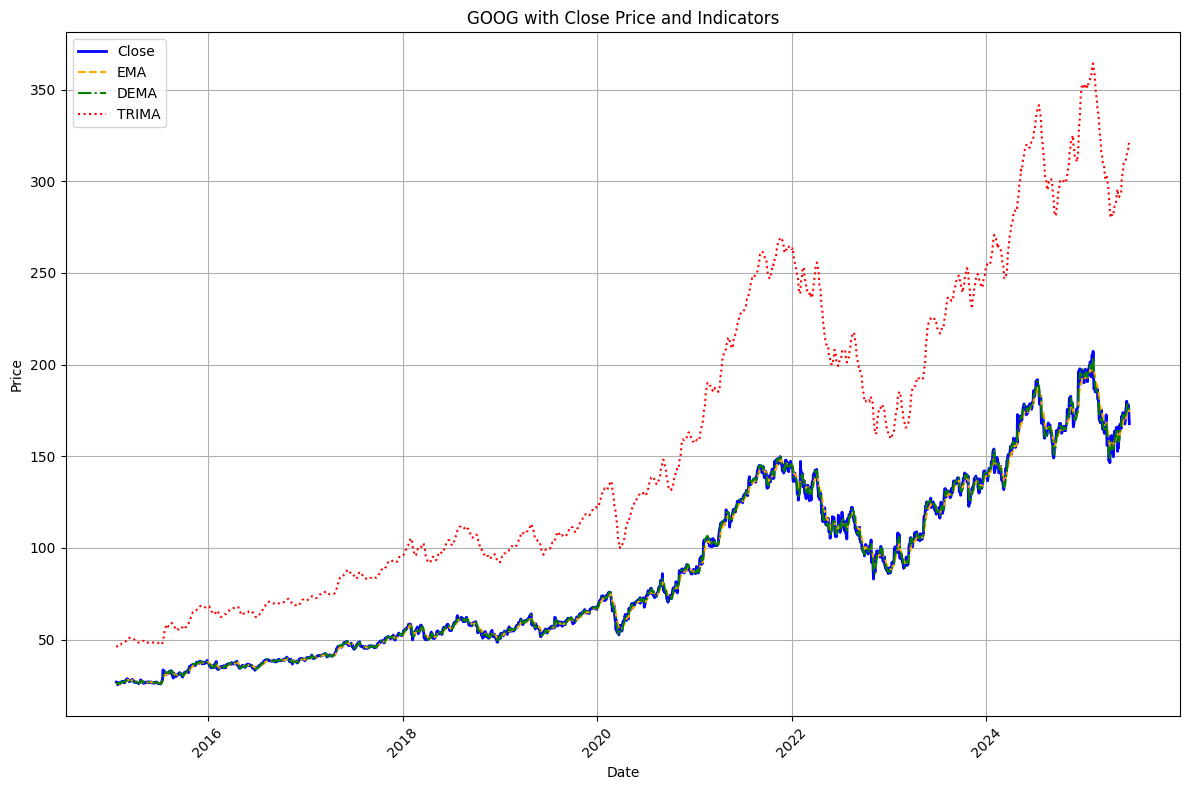

In [5]:
# Plotting with Close Price
plt.figure(figsize=(12, 8))  # Adjust figure size

# Plot Close Price
plt.plot(df1['Close'], label='Close', linewidth=2, color='blue')  # Distinct color for Close

# Plot indicators (only if they exist)
if EMA_indicator and 'EMA' in df1.columns:
    plt.plot(df1['EMA'], label='EMA', linestyle='--', color='orange')
if DEMA_indicator and 'DEMA' in df1.columns:
    plt.plot(df1['DEMA'], label='DEMA', linestyle='-.', color='green')
if TRIMA_indicator and 'TRIMA' in df1.columns:
    plt.plot(df1['TRIMA'], label='TRIMA', linestyle=':', color='red')

plt.title(f"{ticker} with Close Price and Indicators")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# <a name="scaling-the-features"></a>Scaling the Features

In [6]:
df2['predicted_close_price'] = df2['Close'].shift(-1)
df3 = df2.copy().dropna()
min_max_columns = df3.columns.tolist()
min_max_columns.remove('Close')
min_max_columns.remove('predicted_close_price')

#min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
# Apply Min-Max scaling
#df3[min_max_columns] = min_max_scaler.fit_transform(df3[min_max_columns])

# Apply Standardization
df3[min_max_columns] = standard_scaler.fit_transform(df3[min_max_columns])
df3 = df3.copy()
df3

Price,Close,EMA,DEMA,RSI,TRIMA,EMA_derivative,DEMA_derivative,RSI_derivative,TRIMA_derivative,Close_derivative,predicted_close_price
Date,,,,,,,,,,,
2015-01-23,26.764488,-1.290494,-1.284626,0.257170,-1.298197,0.414270,0.495103,0.459153,0.291059,0.132869,26.529531
2015-01-26,26.529531,-1.287071,-1.279672,0.546992,-1.294088,0.008269,0.035534,0.249530,0.033648,-0.076221,25.707691
2015-01-27,25.707691,-1.287445,-1.281876,0.324701,-1.291343,-0.139837,-0.204843,-0.552103,0.172311,-0.515483,25.279915
2015-01-28,25.279915,-1.289403,-1.286619,0.005174,-1.289888,-0.294763,-0.363002,-0.796532,0.042209,-0.282676,25.312628
2015-01-29,25.312628,-1.290878,-1.289979,-0.023593,-1.288858,-0.247597,-0.276898,-0.065632,-0.000557,-0.010625,26.495333
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-12,176.970001,1.877678,1.934534,0.270050,1.854346,0.903620,0.260476,-1.015633,0.798491,-1.105176,175.880005
2025-06-13,175.880005,1.881893,1.929684,0.446220,1.861220,0.308861,-0.369750,0.449532,0.588661,-0.673906,177.940002
2025-06-16,177.940002,1.893298,1.939507,0.223701,1.877729,0.268449,0.136674,-0.179771,0.450361,0.375720,177.229996


# <a name="train-test-split"></a>Train Test Split
We will be splitting the data, training them on a training_subset and then testing them on an unseen testing_subset.

In [7]:
# Define the features (X) and the target variable (Y)
X = df3.drop(columns=['predicted_close_price'], axis = 1)
Y = df3['predicted_close_price']

test_size = 0.2
train_size = int(len(X) * (1 - test_size))
X_train, X_test = X[0:train_size], X[train_size : len(X)]
y_train, y_test = Y[0:train_size], Y[train_size : len(X)]

Grid-Search (finding the best hyper-parameters)
We will be looking for the best hyperparameters:



*   ``number of neurons`` per layer
*   ``batch_size``
*   ``learning_rate``


by grid-search.

In [8]:
def generate_hidden_layer_sizes(num_of_layers, min_neurons=20, max_neurons=40, step=10):
    if num_of_layers < 1:
        raise ValueError("Number of layers must be at least 1.")

    layer_sizes = []
    for _ in range(num_of_layers):
        layer_sizes.append(list(range(min_neurons, max_neurons + 1, step)))

    import itertools
    return list(itertools.product(*layer_sizes))

# Test options for regression
num_folds = 10
scoring = "neg_mean_squared_error"

# Example usage:
hidden_layer_sizes_list = generate_hidden_layer_sizes(num_of_layers=5)

# Define the parameter grid
param_grid = {
    "hidden_layer_sizes": hidden_layer_sizes_list,
    "batch_size": [32, 64, 128],
    "learning_rate_init": [0.001, 0.01, 0.1],
    "alpha": [0.0001, 0.001, 0.01],
    "max_iter": [200, 500, 1000]
}

# Initialize the MLPRegressor with early stopping
model = MLPRegressor(early_stopping=True, validation_fraction=0.1, n_iter_no_change=10)

# Set up K-Fold cross-validation
kfold = KFold(n_splits=num_folds)

# Use RandomizedSearchCV for efficient hyperparameter tuning
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring=scoring, cv=kfold, n_iter=50, n_jobs=-1, random_state=42)
grid_result = grid.fit(X_train, y_train)
best_params = grid_result.best_params_
print(f"Best score is {grid_result.best_score_:.3f} using the parameters {best_params}")
means = grid_result.cv_results_["mean_test_score"]

Best score is -2.157 using the parameters {'max_iter': 200, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (40, 30, 40, 30, 30), 'batch_size': 32, 'alpha': 0.0001}


# <a name="fitting-the-model"></a>Fitting the model

In [9]:
# prepare model
model = MLPRegressor(**best_params)
model.fit(X_train, y_train)

MLPRegressor(batch_size=32, hidden_layer_sizes=(40, 30, 40, 30, 30))

# <a name="performance-metric"></a>Performance metric
The **MSE** gives us the average squared difference between the predictions generated by the model, and the actual stock price. While the $R^2$ tell us how much the independent variable (X) is able to explain the variance of the target(Y).

In [10]:
# estimate accuracy on validation set
from sklearn.metrics import mean_squared_error, r2_score

predictions = model.predict(X_test)
mse_MLP = mean_squared_error(y_test, predictions)
r2_MLP = r2_score(y_test, predictions)

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'R2'],
    'Value': [mse_MLP, r2_MLP]
})

metrics_df.set_index('Metric', inplace=True)
# Display the DataFrame
metrics_df

,Value
Metric,
MSE,8.724045
R2,0.981787


# <a name="plotting-the-predictions"></a>Plotting the predictions

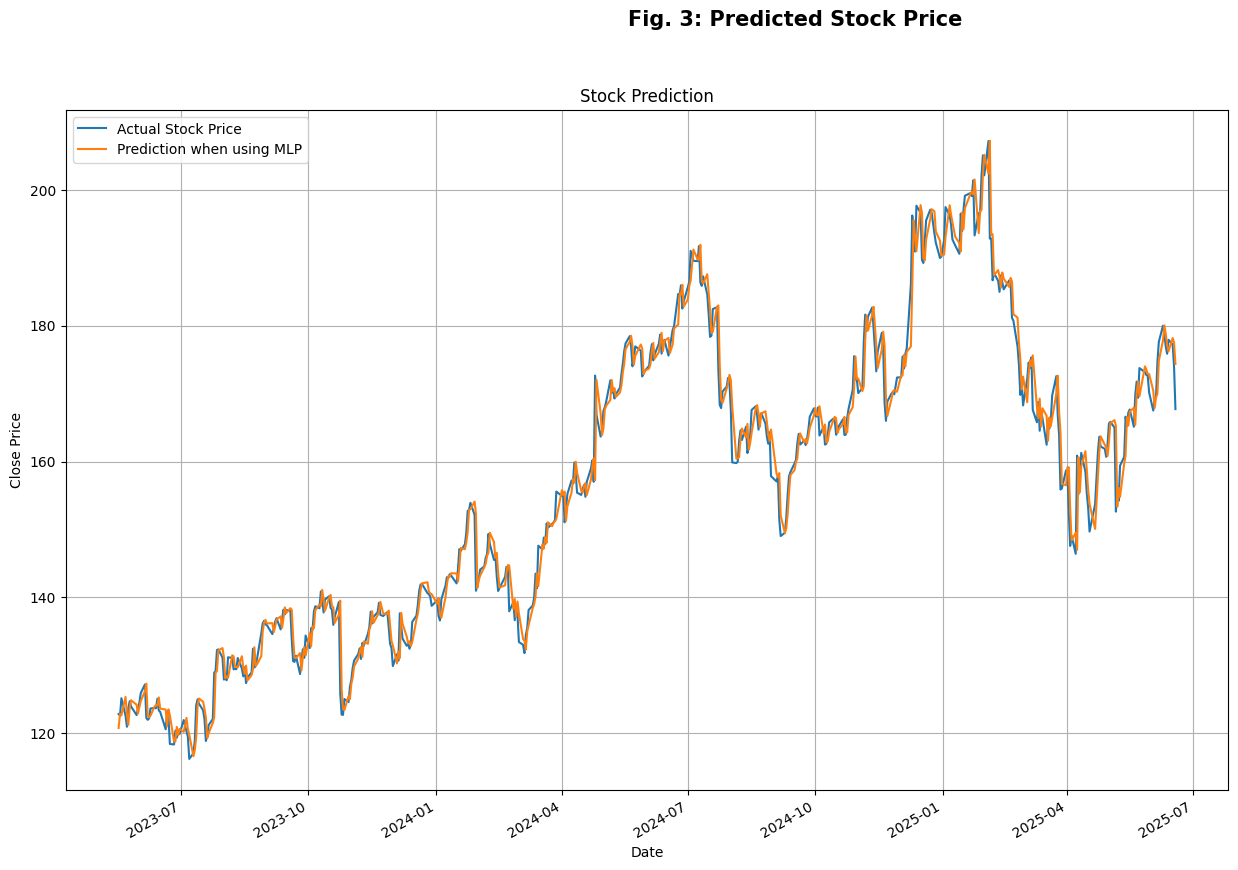

In [11]:
# Create the DataFrame
df = pd.DataFrame({
    "Actual Stock Price": y_test,
    "Prediction when using MLP": predictions,
})

# Create the plot with gridlines
fig, ax = plt.subplots(figsize=(15, 10))  # Create figure and axes for customization
df.plot(kind="line", ax=ax)  # Use ax for finer control
ax.grid(True)  # Enable gridlines on both axes (x and y)

# Add labels and title
ax.set_ylabel("Close Price")
ax.set_title("Stock Prediction")

# Suptitle with bold font, left alignment, and desired font size
plt.suptitle("Fig. 3: Predicted Stock Price", fontweight="bold", ha="left", fontsize=15)

plt.show()